In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
import numpy.linalg as LA
from sklearn import datasets, svm, metrics

import scipy.stats

In [ ]:
CONV1 = 64
CONV2 = 128
DENSE = 128
DROPOUT = 0.1

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Connect GDrive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls gdrive/MyDrive/CSC2515_Project/data/out

test  train  valid


In [ ]:
# setting data paths
ROOT = "gdrive/MyDrive/CSC2515_Project/"
data = "gdrive/MyDrive/CSC2515_Project/data/out"

PCA


In [ ]:
from sklearn.decomposition import KernelPCA 
from PIL import Image

In [ ]:
#function to load images into dataframe
def loaddata(rootdir):
    import os
    imagelist = []
    for (dirpath,dirnames,filenames) in os.walk(rootdir,followlinks=True):
      for file in filenames:
        if '.jpeg' in file:
          datalabel = dirpath.split('/')[-2]
          if (dirpath.split('/')[-1]=='normal'):
            classlabel = 0
          elif (dirpath.split('/')[-1]=='pneumonia'):
            classlabel = 1
          else:
            classlabel = 2
          imagelist.append((dirpath+'/'+ file,datalabel,classlabel))
    return pd.DataFrame(imagelist,columns=['image','data','class'])

In [ ]:
#flatten images to array with additional preprocessing
def flatImages(dataset,selectedLabels):
    vals =[]
    for i in range(len(dataset.values)):
        imgpath = dataset.iloc[i].image
        img = Image.open(imgpath).convert('L') #Luminance or brightness 
        img = img.resize((128,128), Image.ANTIALIAS) #reshape 
        img = np.array(img)
        vmax = img.max()
        vmin = img.min()
        threshold = vmin + 0.9 * (vmax - vmin)
        _, thres = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
        equalized = cv2.equalizeHist(img)
        vals.append(equalized)
    datasetlabels = dataset.loc[:,dataset.columns == 'class']
    trainData= np.array(vals)
    trainlabel= np.array(datasetlabels)
    idx = [k for k in range(len(trainlabel)) if trainlabel[k] in selectedLabels]
    N = len(idx)
    X = np.zeros((N, 128 * 128), dtype=np.uint8)
    T = np.zeros((N, 1), dtype=np.uint8)
    for i in range(N):
        T[i] = trainlabel[idx[i]]
    return trainData,T

In [ ]:
train = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/train')
valid = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/valid')
test = loaddata('gdrive/MyDrive/CSC2515_Project/data/out/test')

from sklearn.utils import shuffle

train = shuffle(train)
valid = shuffle(valid)
test = shuffle(valid)

print(train.shape)
print(valid.shape)
print(test.shape)

train['class'].unique()

(1892, 3)
(399, 3)
(399, 3)


array([1, 2, 0])

In [ ]:
X_train,Y_train = flatImages(train, selectedLabels=[0,1,2])
X_test,Y_test = flatImages(test, selectedLabels=[0,1,2])
X_valid,Y_valid = flatImages(valid, selectedLabels=[0,1,2])

In [ ]:
train['class'].unique()

array([1, 2, 0])

Original

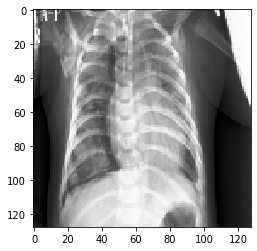

In [ ]:
plt.imshow((X_train[1]).reshape(128,128),interpolation = 'None', cmap = 'gray')

### Statistics

In [ ]:
def to_class(y):
    y_class = []
    for i in y:
        y_class.append(np.argmax(i))
    return np.array(y_class)

In [ ]:
X_train.shape

(1892, 128, 128)

In [ ]:
#plot performance
def plot_model_performance(metric, validations_metric, history):
    plt.plot(history.history[metric],label = str('Training ' + metric))
    plt.plot(history.history[validations_metric],label = str('Validation ' + metric))
    plt.legend()

In [ ]:
batch_size = 256
num_classes = 3
epochs = 10

In [ ]:
img_rows,img_cols = 128,128

In [ ]:
def MODEL(CONV1, CONV2, DENSE, KERNEL_CONV, KERNEL_POOL, ACTIVATION, DROPOUT, OPTIMIZER):

    model = Sequential()
    model.add(Conv2D(CONV1, kernel_size=(KERNEL_CONV, KERNEL_CONV),
                 activation=ACTIVATION,
                 input_shape=(img_rows,img_cols,1)))
    model.add(MaxPooling2D((KERNEL_POOL, KERNEL_POOL)))
    model.add(Conv2D(CONV2, (KERNEL_CONV, KERNEL_CONV), activation='relu'))
    model.add(Flatten())
    model.add(Dense(DENSE, activation=ACTIVATION))
    model.add(Dropout(DROPOUT))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer = OPTIMIZER, metrics = ['accuracy'])
    model.save_weights('model.h5')
    return model

In [ ]:
def mean_confidence_interval(data, confidence=0.95):
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [ ]:
def average_performance(iter, X_train, Y_train, batch_size, epochs, X, Y_true, clf, file):
    
    acc= []
    prec = []
    rec = []
    f1 = []

    for i in range(iter):
        print("Iteration ", i+1)
        clf.load_weights('model.h5')
        hist = clf.fit(X_train.reshape(X_train.shape[0],img_rows,img_cols,1),
                    tf.keras.utils.to_categorical(Y_train,num_classes=3),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.15)
        Y_pred = clf.predict(X)
        Y_pred = to_class(Y_pred)
        acc.append(metrics.accuracy_score(Y_true, Y_pred))
        prec.append(metrics.precision_score(Y_true, Y_pred, average='macro'))
        rec.append(metrics.recall_score(Y_true, Y_pred, average='macro'))
        f1.append(metrics.f1_score(Y_true, Y_pred, average='macro'))

    m_acc, h_acc = mean_confidence_interval(acc, confidence=0.95)
    m_prec, h_prec = mean_confidence_interval(prec, confidence = 0.95)
    m_rec, h_rec = mean_confidence_interval(rec, confidence = 0.95)
    m_f1, h_f1 = mean_confidence_interval(f1, confidence=  0.95)

    print("Mean Accuracy: ", m_acc, "+-", h_acc)
    print("Mean Precision: ", m_prec, "+-", h_prec)
    print("Mean Recall: ", m_rec, "+-", h_rec)
    print("Mean F1: ", m_f1, "+-", h_f1)

### Analysis with Optimizer

In [ ]:
model_adam = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_adam, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 18s 712ms/step - loss: 543.2783 - accuracy: 0.5995 - val_loss: 19.0394 - val_accuracy: 0.7782
Epoch 2/10
7/7 [==============================] - 3s 451ms/step - loss: 3.2481 - accuracy: 0.7687 - val_loss: 0.3936 - val_accuracy: 0.9014
Epoch 3/10
7/7 [==============================] - 3s 451ms/step - loss: 0.2255 - accuracy: 0.9285 - val_loss: 0.2301 - val_accuracy: 0.9225
Epoch 4/10
7/7 [==============================] - 3s 474ms/step - loss: 0.1789 - accuracy: 0.9502 - val_loss: 0.2530 - val_accuracy: 0.9472
Epoch 5/10
7/7 [==============================] - 3s 450ms/step - loss: 0.0896 - accuracy: 0.9720 - val_loss: 0.2737 - val_accuracy: 0.9472
Epoch 6/10
7/7 [==============================] - 3s 452ms/step - loss: 0.0406 - accuracy: 0.9857 - val_loss: 0.2594 - val_accuracy: 0.9401
Epoch 7/10
7/7 [==============================] - 3s 450ms/step - loss: 0.0198 - accuracy: 0.9932 - val_loss: 1.3003 - val_accuracy: 0.8204
Epo

In [ ]:
model_sgd = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='sgd')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_sgd, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 4s 520ms/step - loss: nan - accuracy: 0.4198 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  2
Epoch 1/10
7/7 [==============================] - 3s 443ms/step - loss: nan - accuracy: 0.4776 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 449ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 425ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  3
Epoch 1/10
7/7 [==============================] - 3s 440ms/step - loss: nan - accuracy: 0.4086 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 425ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  4
Epoch 1/10
7/7 [==============================] - 3s 438ms/step - loss: nan - accuracy: 0.3986 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 430ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  5
Epoch 1/10
7/7 [==============================] - 3s 440ms/step - loss: nan - accuracy: 0.5062 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 425ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 425ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  6
Epoch 1/10
7/7 [==============================] - 3s 442ms/step - loss: nan - accuracy: 0.3949 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  7
Epoch 1/10
7/7 [==============================] - 3s 438ms/step - loss: nan - accuracy: 0.4136 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 425ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  8
Epoch 1/10
7/7 [==============================] - 3s 467ms/step - loss: nan - accuracy: 0.4011 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  9
Epoch 1/10
7/7 [==============================] - 3s 443ms/step - loss: nan - accuracy: 0.3980 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 424ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  10
Epoch 1/10
7/7 [==============================] - 3s 440ms/step - loss: 45352567802311714275328.0000 - accuracy: 0.5361 - val_loss: 1.0839 - val_accuracy: 0.7782
Epoch 2/10
7/7 [==============================] - 3s 427ms/step - loss: 1.0755 - accuracy: 0.7910 - val_loss: 1.0637 - val_accuracy: 0.7782
Epoch 3/10
7/7 [==============================] - 3s 429ms/step - loss: 1.0551 - accuracy: 0.7910 - val_loss: 1.0444 - val_accuracy: 0.7782
Epoch 4/10
7/7 [==============================] - 3s 431ms/step - loss: 1.0356 - accuracy: 0.7910 - val_loss: 1.0259 - val_accuracy: 0.7782
Epoch 5/10
7/7 [==============================] - 3s 430ms/step - loss: 1.0169 - accuracy: 0.7910 - val_loss: 1.0089 - val_accuracy: 0.7782
Epoch 6/10
7/7 [==============================] - 3s 430ms/step - loss: 0.9996 - accuracy: 0.7910 - val_loss: 0.9921 - val_accuracy: 0.7782
Epoch 7/10
7/7 [==============================] - 3s 429ms/step - loss: 0.9827 - accuracy: 0.7910 - val_loss: 0.9763 - val_a

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  11
Epoch 1/10
7/7 [==============================] - 3s 443ms/step - loss: nan - accuracy: 0.4092 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 448ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  12
Epoch 1/10
7/7 [==============================] - 3s 440ms/step - loss: nan - accuracy: 0.3980 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 430ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 452ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  13
Epoch 1/10
7/7 [==============================] - 3s 444ms/step - loss: nan - accuracy: 0.4932 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  14
Epoch 1/10
7/7 [==============================] - 3s 463ms/step - loss: nan - accuracy: 0.5168 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 425ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 425ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  15
Epoch 1/10
7/7 [==============================] - 3s 462ms/step - loss: nan - accuracy: 0.4223 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 425ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 425ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  16
Epoch 1/10
7/7 [==============================] - 3s 440ms/step - loss: nan - accuracy: 0.4136 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 449ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 431ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  17
Epoch 1/10
7/7 [==============================] - 3s 442ms/step - loss: nan - accuracy: 0.3912 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 430ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  18
Epoch 1/10
7/7 [==============================] - 3s 442ms/step - loss: 274743808729476205703214349156352.0000 - accuracy: 0.4919 - val_loss: 1.0904 - val_accuracy: 0.7782
Epoch 2/10
7/7 [==============================] - 3s 425ms/step - loss: 1.0819 - accuracy: 0.7910 - val_loss: 1.0702 - val_accuracy: 0.7782
Epoch 3/10
7/7 [==============================] - 3s 426ms/step - loss: 1.0615 - accuracy: 0.7910 - val_loss: 1.0506 - val_accuracy: 0.7782
Epoch 4/10
7/7 [==============================] - 3s 428ms/step - loss: 1.0417 - accuracy: 0.7910 - val_loss: 1.0319 - val_accuracy: 0.7782
Epoch 5/10
7/7 [==============================] - 3s 424ms/step - loss: 1.0228 - accuracy: 0.7910 - val_loss: 1.0142 - val_accuracy: 0.7782
Epoch 6/10
7/7 [==============================] - 3s 426ms/step - loss: 1.0049 - accuracy: 0.7910 - val_loss: 0.9971 - val_accuracy: 0.7782
Epoch 7/10
7/7 [==============================] - 3s 427ms/step - loss: 0.9876 - accuracy: 0.7910 - val_loss: 0.98

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  19
Epoch 1/10
7/7 [==============================] - 3s 461ms/step - loss: nan - accuracy: 0.4266 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 451ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 449ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  20
Epoch 1/10
7/7 [==============================] - 3s 440ms/step - loss: nan - accuracy: 0.3930 - val_loss: nan - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 3/10
7/7 [==============================] - 3s 428ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 4/10
7/7 [==============================] - 3s 429ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 5/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 6/10
7/7 [==============================] - 3s 427ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 7/10
7/7 [==============================] - 3s 426ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.1373
Epoch 8/10
7/7 [==============================] 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_rmsprop = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='rmsprop')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_rmsprop, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 4s 501ms/step - loss: 3440.3340 - accuracy: 0.5031 - val_loss: 1.2225 - val_accuracy: 0.7993
Epoch 2/10
7/7 [==============================] - 3s 464ms/step - loss: 4.9915 - accuracy: 0.7313 - val_loss: 1.3509 - val_accuracy: 0.8697
Epoch 3/10
7/7 [==============================] - 3s 464ms/step - loss: 14.2401 - accuracy: 0.6468 - val_loss: 0.5043 - val_accuracy: 0.9120
Epoch 4/10
7/7 [==============================] - 3s 466ms/step - loss: 0.2581 - accuracy: 0.9428 - val_loss: 0.3083 - val_accuracy: 0.9437
Epoch 5/10
7/7 [==============================] - 3s 467ms/step - loss: 0.1212 - accuracy: 0.9701 - val_loss: 0.3300 - val_accuracy: 0.9472
Epoch 6/10
7/7 [==============================] - 3s 468ms/step - loss: 0.0632 - accuracy: 0.9807 - val_loss: 0.6050 - val_accuracy: 0.9120
Epoch 7/10
7/7 [==============================] - 3s 488ms/step - loss: 0.0912 - accuracy: 0.9751 - val_loss: 0.2496 - val_accuracy: 0.9507
Epo

In [ ]:
model_adagrad = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adagrad')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_adagrad, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 4s 477ms/step - loss: 524.6045 - accuracy: 0.6200 - val_loss: 37.8985 - val_accuracy: 0.8099
Epoch 2/10
7/7 [==============================] - 3s 443ms/step - loss: 23.7503 - accuracy: 0.7780 - val_loss: 4.4831 - val_accuracy: 0.8662
Epoch 3/10
7/7 [==============================] - 3s 446ms/step - loss: 12.3450 - accuracy: 0.7898 - val_loss: 7.1339 - val_accuracy: 0.8521
Epoch 4/10
7/7 [==============================] - 3s 448ms/step - loss: 7.9928 - accuracy: 0.8221 - val_loss: 6.4966 - val_accuracy: 0.8380
Epoch 5/10
7/7 [==============================] - 3s 447ms/step - loss: 9.3123 - accuracy: 0.7830 - val_loss: 0.9694 - val_accuracy: 0.9155
Epoch 6/10
7/7 [==============================] - 3s 449ms/step - loss: 2.5082 - accuracy: 0.8582 - val_loss: 1.0379 - val_accuracy: 0.9049
Epoch 7/10
7/7 [==============================] - 3s 448ms/step - loss: 1.7728 - accuracy: 0.8694 - val_loss: 0.5803 - val_accuracy: 0.9261
Ep

In [ ]:
model_adadelta = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adadelta')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_adadelta, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 4s 489ms/step - loss: 6.0501 - accuracy: 0.5920 - val_loss: 1.2813 - val_accuracy: 0.7218
Epoch 2/10
7/7 [==============================] - 3s 460ms/step - loss: 2.1290 - accuracy: 0.7550 - val_loss: 0.8027 - val_accuracy: 0.7887
Epoch 3/10
7/7 [==============================] - 3s 461ms/step - loss: 1.7152 - accuracy: 0.7780 - val_loss: 2.4653 - val_accuracy: 0.8451
Epoch 4/10
7/7 [==============================] - 3s 460ms/step - loss: 1.3473 - accuracy: 0.8190 - val_loss: 2.3014 - val_accuracy: 0.8310
Epoch 5/10
7/7 [==============================] - 3s 463ms/step - loss: 1.2670 - accuracy: 0.8451 - val_loss: 0.6160 - val_accuracy: 0.8838
Epoch 6/10
7/7 [==============================] - 3s 460ms/step - loss: 1.0904 - accuracy: 0.8358 - val_loss: 0.6155 - val_accuracy: 0.8873
Epoch 7/10
7/7 [==============================] - 3s 461ms/step - loss: 0.8301 - accuracy: 0.8539 - val_loss: 0.4623 - val_accuracy: 0.8768
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  9
Epoch 1/10
7/7 [==============================] - 3s 487ms/step - loss: 6.3235 - accuracy: 0.6082 - val_loss: 0.9388 - val_accuracy: 0.7394
Epoch 2/10
7/7 [==============================] - 3s 459ms/step - loss: 2.2733 - accuracy: 0.7164 - val_loss: 1.0168 - val_accuracy: 0.8556
Epoch 3/10
7/7 [==============================] - 3s 460ms/step - loss: 1.4937 - accuracy: 0.7867 - val_loss: 0.4244 - val_accuracy: 0.8873
Epoch 4/10
7/7 [==============================] - 3s 481ms/step - loss: 1.6732 - accuracy: 0.7811 - val_loss: 0.4051 - val_accuracy: 0.8838
Epoch 5/10
7/7 [==============================] - 3s 459ms/step - loss: 0.9849 - accuracy: 0.8327 - val_loss: 2.4095 - val_accuracy: 0.8310
Epoch 6/10
7/7 [==============================] - 3s 457ms/step - loss: 1.1768 - accuracy: 0.8402 - val_loss: 0.5227 - val_accuracy: 0.8908
Epoch 7/10
7/7 [==============================] - 3s 459ms/step - loss: 0.6728 - accuracy: 0.8744 - val_loss: 1.2704 - val_accuracy: 0.8627
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  20
Epoch 1/10
7/7 [==============================] - 3s 463ms/step - loss: 5.8531 - accuracy: 0.6318 - val_loss: 0.8709 - val_accuracy: 0.8169
Epoch 2/10
7/7 [==============================] - 3s 458ms/step - loss: 2.1225 - accuracy: 0.7500 - val_loss: 0.7155 - val_accuracy: 0.8627
Epoch 3/10
7/7 [==============================] - 3s 460ms/step - loss: 1.6998 - accuracy: 0.7836 - val_loss: 0.6268 - val_accuracy: 0.8662
Epoch 4/10
7/7 [==============================] - 3s 461ms/step - loss: 1.0999 - accuracy: 0.8228 - val_loss: 0.4676 - val_accuracy: 0.8979
Epoch 5/10
7/7 [==============================] - 3s 460ms/step - loss: 1.6119 - accuracy: 0.8078 - val_loss: 0.3261 - val_accuracy: 0.9014
Epoch 6/10
7/7 [==============================] - 3s 460ms/step - loss: 0.7172 - accuracy: 0.8688 - val_loss: 0.3454 - val_accuracy: 0.9085
Epoch 7/10
7/7 [==============================] - 3s 483ms/step - loss: 0.7277 - accuracy: 0.8663 - val_loss: 2.1910 - val_accuracy: 0.8451
Epoch 

### Analysis with Dropout

In [ ]:
model_10 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_10, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 4s 484ms/step - loss: 1682.3391 - accuracy: 0.5933 - val_loss: 144.9523 - val_accuracy: 0.1373
Epoch 2/10
7/7 [==============================] - 3s 452ms/step - loss: 41.3021 - accuracy: 0.6045 - val_loss: 42.2899 - val_accuracy: 0.1620
Epoch 3/10
7/7 [==============================] - 3s 450ms/step - loss: 8.9859 - accuracy: 0.6922 - val_loss: 1.2483 - val_accuracy: 0.8908
Epoch 4/10
7/7 [==============================] - 3s 450ms/step - loss: 0.5761 - accuracy: 0.9285 - val_loss: 0.7473 - val_accuracy: 0.9190
Epoch 5/10
7/7 [==============================] - 3s 452ms/step - loss: 0.2590 - accuracy: 0.9577 - val_loss: 0.3064 - val_accuracy: 0.9472
Epoch 6/10
7/7 [==============================] - 3s 449ms/step - loss: 0.0937 - accuracy: 0.9764 - val_loss: 0.2264 - val_accuracy: 0.9542
Epoch 7/10
7/7 [==============================] - 3s 448ms/step - loss: 0.0263 - accuracy: 0.9900 - val_loss: 0.2165 - val_accuracy: 0.9683


In [ ]:
model_20 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.2, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_20, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 4s 484ms/step - loss: 2023.6948 - accuracy: 0.6169 - val_loss: 80.9377 - val_accuracy: 0.8134
Epoch 2/10
7/7 [==============================] - 3s 450ms/step - loss: 32.2605 - accuracy: 0.6580 - val_loss: 0.5880 - val_accuracy: 0.8275
Epoch 3/10
7/7 [==============================] - 3s 450ms/step - loss: 0.4518 - accuracy: 0.8470 - val_loss: 0.2425 - val_accuracy: 0.9014
Epoch 4/10
7/7 [==============================] - 3s 448ms/step - loss: 0.2140 - accuracy: 0.9198 - val_loss: 0.1973 - val_accuracy: 0.9366
Epoch 5/10
7/7 [==============================] - 3s 449ms/step - loss: 0.1323 - accuracy: 0.9490 - val_loss: 0.1746 - val_accuracy: 0.9437
Epoch 6/10
7/7 [==============================] - 3s 448ms/step - loss: 0.0708 - accuracy: 0.9745 - val_loss: 0.1364 - val_accuracy: 0.9648
Epoch 7/10
7/7 [==============================] - 3s 450ms/step - loss: 0.0363 - accuracy: 0.9888 - val_loss: 0.1548 - val_accuracy: 0.9754
Ep

In [ ]:
model_30 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.3, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_30, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 4s 476ms/step - loss: 1004.7924 - accuracy: 0.6007 - val_loss: 2.5975 - val_accuracy: 0.8099
Epoch 2/10
7/7 [==============================] - 3s 447ms/step - loss: 2.1659 - accuracy: 0.6374 - val_loss: 0.4812 - val_accuracy: 0.8415
Epoch 3/10
7/7 [==============================] - 3s 444ms/step - loss: 0.3301 - accuracy: 0.9104 - val_loss: 0.3322 - val_accuracy: 0.9049
Epoch 4/10
7/7 [==============================] - 3s 444ms/step - loss: 0.1441 - accuracy: 0.9590 - val_loss: 0.3132 - val_accuracy: 0.9366
Epoch 5/10
7/7 [==============================] - 3s 442ms/step - loss: 0.0697 - accuracy: 0.9776 - val_loss: 0.2900 - val_accuracy: 0.9366
Epoch 6/10
7/7 [==============================] - 3s 443ms/step - loss: 0.0468 - accuracy: 0.9857 - val_loss: 0.4055 - val_accuracy: 0.9331
Epoch 7/10
7/7 [==============================] - 3s 443ms/step - loss: 0.0382 - accuracy: 0.9851 - val_loss: 0.3014 - val_accuracy: 0.9261
Epoc

In [ ]:
model_40 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.4, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_40, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 4s 476ms/step - loss: 998.2883 - accuracy: 0.6256 - val_loss: 0.9286 - val_accuracy: 0.6831
Epoch 2/10
7/7 [==============================] - 3s 446ms/step - loss: 0.8080 - accuracy: 0.7898 - val_loss: 0.7216 - val_accuracy: 0.8556
Epoch 3/10
7/7 [==============================] - 3s 446ms/step - loss: 0.6470 - accuracy: 0.8588 - val_loss: 0.4315 - val_accuracy: 0.8803
Epoch 4/10
7/7 [==============================] - 3s 445ms/step - loss: 0.5926 - accuracy: 0.8725 - val_loss: 0.4290 - val_accuracy: 0.9155
Epoch 5/10
7/7 [==============================] - 3s 444ms/step - loss: 0.2151 - accuracy: 0.9359 - val_loss: 0.3060 - val_accuracy: 0.9261
Epoch 6/10
7/7 [==============================] - 3s 446ms/step - loss: 0.1476 - accuracy: 0.9627 - val_loss: 0.4301 - val_accuracy: 0.9120
Epoch 7/10
7/7 [==============================] - 3s 467ms/step - loss: 0.0734 - accuracy: 0.9745 - val_loss: 0.3736 - val_accuracy: 0.9296
Epoch

In [ ]:
model_50 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.5, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_50, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 10s 711ms/step - loss: 659.5336 - accuracy: 0.6443 - val_loss: 11.3173 - val_accuracy: 0.8099
Epoch 2/10
7/7 [==============================] - 3s 452ms/step - loss: 16.2674 - accuracy: 0.5504 - val_loss: 0.3786 - val_accuracy: 0.8979
Epoch 3/10
7/7 [==============================] - 3s 453ms/step - loss: 0.3761 - accuracy: 0.8980 - val_loss: 0.3624 - val_accuracy: 0.9120
Epoch 4/10
7/7 [==============================] - 3s 452ms/step - loss: 0.1589 - accuracy: 0.9447 - val_loss: 0.1875 - val_accuracy: 0.9472
Epoch 5/10
7/7 [==============================] - 3s 452ms/step - loss: 0.1039 - accuracy: 0.9677 - val_loss: 0.1955 - val_accuracy: 0.9577
Epoch 6/10
7/7 [==============================] - 3s 448ms/step - loss: 0.0562 - accuracy: 0.9789 - val_loss: 0.2408 - val_accuracy: 0.9683
Epoch 7/10
7/7 [==============================] - 3s 452ms/step - loss: 0.0513 - accuracy: 0.9857 - val_loss: 0.1973 - val_accuracy: 0.9613
Ep

### Analysis with Activation Function

In [ ]:
model_tanh = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='tanh', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_tanh, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 8s 673ms/step - loss: 2.7977 - accuracy: 0.6760 - val_loss: 2.5615 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 431ms/step - loss: 2.6544 - accuracy: 0.7867 - val_loss: 2.2435 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 429ms/step - loss: 2.3202 - accuracy: 0.7867 - val_loss: 1.9094 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 431ms/step - loss: 1.9444 - accuracy: 0.7867 - val_loss: 1.5781 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 431ms/step - loss: 1.6025 - accuracy: 0.7867 - val_loss: 1.2659 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 433ms/step - loss: 1.2877 - accuracy: 0.7867 - val_loss: 1.0674 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 432ms/step - loss: 1.1434 - accuracy: 0.7830 - val_loss: 1.0143 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  2
Epoch 1/10
7/7 [==============================] - 3s 437ms/step - loss: 2.7693 - accuracy: 0.6816 - val_loss: 2.6297 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 430ms/step - loss: 2.7511 - accuracy: 0.7867 - val_loss: 2.3464 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 432ms/step - loss: 2.4203 - accuracy: 0.7867 - val_loss: 2.0065 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 452ms/step - loss: 2.0517 - accuracy: 0.7867 - val_loss: 1.6431 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 447ms/step - loss: 1.6429 - accuracy: 0.7867 - val_loss: 1.2829 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 432ms/step - loss: 1.2756 - accuracy: 0.7867 - val_loss: 1.0076 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 431ms/step - loss: 1.0676 - accuracy: 0.7861 - val_loss: 0.9280 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  3
Epoch 1/10
7/7 [==============================] - 3s 444ms/step - loss: 2.7679 - accuracy: 0.6810 - val_loss: 2.6591 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 434ms/step - loss: 2.7845 - accuracy: 0.7867 - val_loss: 2.3711 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 432ms/step - loss: 2.4380 - accuracy: 0.7867 - val_loss: 2.0251 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 434ms/step - loss: 2.0566 - accuracy: 0.7867 - val_loss: 1.6507 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 436ms/step - loss: 1.6346 - accuracy: 0.7867 - val_loss: 1.2768 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 433ms/step - loss: 1.2560 - accuracy: 0.7867 - val_loss: 0.9777 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 431ms/step - loss: 1.0222 - accuracy: 0.7848 - val_loss: 0.8925 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  4
Epoch 1/10
7/7 [==============================] - 3s 443ms/step - loss: 3.0109 - accuracy: 0.6698 - val_loss: 2.7732 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 431ms/step - loss: 2.8928 - accuracy: 0.7867 - val_loss: 2.4839 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 431ms/step - loss: 2.5499 - accuracy: 0.7867 - val_loss: 2.1435 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 430ms/step - loss: 2.1927 - accuracy: 0.7867 - val_loss: 1.7672 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 431ms/step - loss: 1.7654 - accuracy: 0.7867 - val_loss: 1.3817 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 432ms/step - loss: 1.3459 - accuracy: 0.7867 - val_loss: 1.0163 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 431ms/step - loss: 1.0038 - accuracy: 0.7867 - val_loss: 0.7968 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  5
Epoch 1/10
7/7 [==============================] - 3s 437ms/step - loss: 2.8564 - accuracy: 0.6748 - val_loss: 2.6736 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 431ms/step - loss: 2.8108 - accuracy: 0.7867 - val_loss: 2.4054 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 432ms/step - loss: 2.4784 - accuracy: 0.7867 - val_loss: 2.0619 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 430ms/step - loss: 2.0872 - accuracy: 0.7867 - val_loss: 1.6766 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 435ms/step - loss: 1.6756 - accuracy: 0.7867 - val_loss: 1.3028 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 432ms/step - loss: 1.2995 - accuracy: 0.7867 - val_loss: 1.0092 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 433ms/step - loss: 1.0553 - accuracy: 0.7836 - val_loss: 0.9265 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  6
Epoch 1/10
7/7 [==============================] - 3s 438ms/step - loss: 2.9510 - accuracy: 0.6741 - val_loss: 2.7468 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 445ms/step - loss: 2.8800 - accuracy: 0.7867 - val_loss: 2.4754 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 432ms/step - loss: 2.5666 - accuracy: 0.7867 - val_loss: 2.1337 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 431ms/step - loss: 2.1719 - accuracy: 0.7867 - val_loss: 1.7725 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 431ms/step - loss: 1.7744 - accuracy: 0.7867 - val_loss: 1.3937 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 431ms/step - loss: 1.3644 - accuracy: 0.7867 - val_loss: 1.0326 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 432ms/step - loss: 1.0223 - accuracy: 0.7867 - val_loss: 0.8172 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  7
Epoch 1/10
7/7 [==============================] - 3s 442ms/step - loss: 2.8034 - accuracy: 0.6859 - val_loss: 2.7206 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 433ms/step - loss: 2.8552 - accuracy: 0.7867 - val_loss: 2.4511 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 430ms/step - loss: 2.5269 - accuracy: 0.7867 - val_loss: 2.1072 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 432ms/step - loss: 2.1398 - accuracy: 0.7867 - val_loss: 1.7367 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 432ms/step - loss: 1.7276 - accuracy: 0.7867 - val_loss: 1.3576 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 432ms/step - loss: 1.3344 - accuracy: 0.7867 - val_loss: 1.0111 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 430ms/step - loss: 1.0150 - accuracy: 0.7867 - val_loss: 0.8476 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  8
Epoch 1/10
7/7 [==============================] - 3s 438ms/step - loss: 3.0623 - accuracy: 0.6629 - val_loss: 2.7681 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 431ms/step - loss: 2.9011 - accuracy: 0.7867 - val_loss: 2.4921 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 432ms/step - loss: 2.5682 - accuracy: 0.7867 - val_loss: 2.1518 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 432ms/step - loss: 2.1906 - accuracy: 0.7867 - val_loss: 1.7841 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 430ms/step - loss: 1.7788 - accuracy: 0.7867 - val_loss: 1.4004 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 431ms/step - loss: 1.3702 - accuracy: 0.7867 - val_loss: 1.0373 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 430ms/step - loss: 1.0342 - accuracy: 0.7867 - val_loss: 0.8109 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  9
Epoch 1/10
7/7 [==============================] - 3s 440ms/step - loss: 2.8049 - accuracy: 0.6828 - val_loss: 2.6848 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 434ms/step - loss: 2.8255 - accuracy: 0.7867 - val_loss: 2.4331 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 456ms/step - loss: 2.5292 - accuracy: 0.7867 - val_loss: 2.1153 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 433ms/step - loss: 2.1520 - accuracy: 0.7867 - val_loss: 1.7606 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 433ms/step - loss: 1.7675 - accuracy: 0.7867 - val_loss: 1.3847 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 434ms/step - loss: 1.3779 - accuracy: 0.7867 - val_loss: 1.0541 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 433ms/step - loss: 1.0857 - accuracy: 0.7867 - val_loss: 0.9112 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  10
Epoch 1/10
7/7 [==============================] - 3s 442ms/step - loss: 2.9684 - accuracy: 0.6766 - val_loss: 2.7783 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 456ms/step - loss: 2.9104 - accuracy: 0.7867 - val_loss: 2.4993 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 429ms/step - loss: 2.5730 - accuracy: 0.7867 - val_loss: 2.1599 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 433ms/step - loss: 2.2003 - accuracy: 0.7867 - val_loss: 1.7857 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 431ms/step - loss: 1.7779 - accuracy: 0.7867 - val_loss: 1.4032 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 433ms/step - loss: 1.3648 - accuracy: 0.7867 - val_loss: 1.0363 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 433ms/step - loss: 1.0150 - accuracy: 0.7867 - val_loss: 0.7943 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  11
Epoch 1/10
7/7 [==============================] - 3s 439ms/step - loss: 2.8635 - accuracy: 0.6754 - val_loss: 2.6896 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 434ms/step - loss: 2.8242 - accuracy: 0.7867 - val_loss: 2.4388 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 433ms/step - loss: 2.5252 - accuracy: 0.7867 - val_loss: 2.1122 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 430ms/step - loss: 2.1492 - accuracy: 0.7867 - val_loss: 1.7520 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 431ms/step - loss: 1.7677 - accuracy: 0.7867 - val_loss: 1.3766 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 434ms/step - loss: 1.3590 - accuracy: 0.7867 - val_loss: 1.0562 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 435ms/step - loss: 1.0793 - accuracy: 0.7861 - val_loss: 0.9269 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  12
Epoch 1/10
7/7 [==============================] - 3s 441ms/step - loss: 3.0135 - accuracy: 0.6710 - val_loss: 2.7823 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 430ms/step - loss: 2.9168 - accuracy: 0.7867 - val_loss: 2.5096 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 430ms/step - loss: 2.6010 - accuracy: 0.7867 - val_loss: 2.1665 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 432ms/step - loss: 2.1930 - accuracy: 0.7867 - val_loss: 1.7874 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 435ms/step - loss: 1.7795 - accuracy: 0.7867 - val_loss: 1.3986 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 432ms/step - loss: 1.3635 - accuracy: 0.7867 - val_loss: 1.0295 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 430ms/step - loss: 1.0026 - accuracy: 0.7867 - val_loss: 0.7824 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  13
Epoch 1/10
7/7 [==============================] - 3s 440ms/step - loss: 2.9770 - accuracy: 0.6791 - val_loss: 2.8302 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 430ms/step - loss: 2.9652 - accuracy: 0.7867 - val_loss: 2.5808 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 433ms/step - loss: 2.6763 - accuracy: 0.7867 - val_loss: 2.2467 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 429ms/step - loss: 2.2957 - accuracy: 0.7867 - val_loss: 1.8768 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 432ms/step - loss: 1.8753 - accuracy: 0.7867 - val_loss: 1.4961 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 431ms/step - loss: 1.4684 - accuracy: 0.7867 - val_loss: 1.1181 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 433ms/step - loss: 1.0825 - accuracy: 0.7867 - val_loss: 0.8330 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  14
Epoch 1/10
7/7 [==============================] - 3s 440ms/step - loss: 2.9633 - accuracy: 0.6710 - val_loss: 2.7388 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 433ms/step - loss: 2.8740 - accuracy: 0.7867 - val_loss: 2.4755 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 431ms/step - loss: 2.5490 - accuracy: 0.7867 - val_loss: 2.1359 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 432ms/step - loss: 2.1792 - accuracy: 0.7867 - val_loss: 1.7635 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 459ms/step - loss: 1.7760 - accuracy: 0.7867 - val_loss: 1.3866 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 431ms/step - loss: 1.3630 - accuracy: 0.7867 - val_loss: 1.0370 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 430ms/step - loss: 1.0321 - accuracy: 0.7861 - val_loss: 0.8478 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  15
Epoch 1/10
7/7 [==============================] - 3s 439ms/step - loss: 2.8491 - accuracy: 0.6853 - val_loss: 2.7742 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 433ms/step - loss: 2.9018 - accuracy: 0.7867 - val_loss: 2.5126 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 431ms/step - loss: 2.5980 - accuracy: 0.7867 - val_loss: 2.1816 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 430ms/step - loss: 2.2155 - accuracy: 0.7867 - val_loss: 1.8153 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 431ms/step - loss: 1.8156 - accuracy: 0.7867 - val_loss: 1.4321 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 431ms/step - loss: 1.4087 - accuracy: 0.7867 - val_loss: 1.0726 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 430ms/step - loss: 1.0544 - accuracy: 0.7867 - val_loss: 0.8219 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  16
Epoch 1/10
7/7 [==============================] - 3s 465ms/step - loss: 2.7917 - accuracy: 0.6816 - val_loss: 2.6884 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 431ms/step - loss: 2.8340 - accuracy: 0.7867 - val_loss: 2.4350 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 430ms/step - loss: 2.5145 - accuracy: 0.7867 - val_loss: 2.1103 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 432ms/step - loss: 2.1483 - accuracy: 0.7867 - val_loss: 1.7431 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 431ms/step - loss: 1.7502 - accuracy: 0.7867 - val_loss: 1.3705 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 431ms/step - loss: 1.3601 - accuracy: 0.7867 - val_loss: 1.0465 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 431ms/step - loss: 1.0726 - accuracy: 0.7873 - val_loss: 0.9126 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  17
Epoch 1/10
7/7 [==============================] - 3s 441ms/step - loss: 2.8644 - accuracy: 0.6741 - val_loss: 2.6838 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 431ms/step - loss: 2.8223 - accuracy: 0.7867 - val_loss: 2.4047 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 431ms/step - loss: 2.4814 - accuracy: 0.7867 - val_loss: 2.0652 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 433ms/step - loss: 2.0999 - accuracy: 0.7867 - val_loss: 1.7008 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 430ms/step - loss: 1.7018 - accuracy: 0.7867 - val_loss: 1.3220 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 430ms/step - loss: 1.2994 - accuracy: 0.7867 - val_loss: 0.9910 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 431ms/step - loss: 1.0082 - accuracy: 0.7861 - val_loss: 0.8522 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  18
Epoch 1/10
7/7 [==============================] - 3s 441ms/step - loss: 2.7364 - accuracy: 0.6866 - val_loss: 2.6677 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 431ms/step - loss: 2.8029 - accuracy: 0.7867 - val_loss: 2.4013 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 431ms/step - loss: 2.4706 - accuracy: 0.7867 - val_loss: 2.0612 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 430ms/step - loss: 2.0850 - accuracy: 0.7867 - val_loss: 1.6943 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 434ms/step - loss: 1.6877 - accuracy: 0.7867 - val_loss: 1.3209 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 431ms/step - loss: 1.3048 - accuracy: 0.7867 - val_loss: 1.0154 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 430ms/step - loss: 1.0490 - accuracy: 0.7842 - val_loss: 0.9096 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  19
Epoch 1/10
7/7 [==============================] - 3s 437ms/step - loss: 2.9477 - accuracy: 0.6710 - val_loss: 2.6973 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 430ms/step - loss: 2.8195 - accuracy: 0.7867 - val_loss: 2.4204 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 430ms/step - loss: 2.4934 - accuracy: 0.7867 - val_loss: 2.0826 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 430ms/step - loss: 2.1111 - accuracy: 0.7867 - val_loss: 1.7081 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 429ms/step - loss: 1.7111 - accuracy: 0.7867 - val_loss: 1.3259 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 430ms/step - loss: 1.3060 - accuracy: 0.7867 - val_loss: 0.9835 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 430ms/step - loss: 1.0009 - accuracy: 0.7867 - val_loss: 0.8405 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  20
Epoch 1/10
7/7 [==============================] - 3s 442ms/step - loss: 3.0272 - accuracy: 0.6660 - val_loss: 2.7647 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 430ms/step - loss: 2.8936 - accuracy: 0.7867 - val_loss: 2.4941 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 432ms/step - loss: 2.5688 - accuracy: 0.7867 - val_loss: 2.1538 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 431ms/step - loss: 2.1995 - accuracy: 0.7867 - val_loss: 1.7756 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 430ms/step - loss: 1.7783 - accuracy: 0.7867 - val_loss: 1.3974 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 432ms/step - loss: 1.3740 - accuracy: 0.7867 - val_loss: 1.0306 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 429ms/step - loss: 1.0218 - accuracy: 0.7867 - val_loss: 0.8072 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_sigmoid = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='sigmoid', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_sigmoid, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 4s 468ms/step - loss: 1.5472 - accuracy: 0.7307 - val_loss: 1.4734 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 435ms/step - loss: 1.5291 - accuracy: 0.7867 - val_loss: 1.3152 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 434ms/step - loss: 1.3446 - accuracy: 0.7867 - val_loss: 1.1494 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 434ms/step - loss: 1.1770 - accuracy: 0.7867 - val_loss: 0.9839 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 435ms/step - loss: 1.0009 - accuracy: 0.7867 - val_loss: 0.8326 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 436ms/step - loss: 0.8515 - accuracy: 0.7867 - val_loss: 0.7144 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 436ms/step - loss: 0.7413 - accuracy: 0.7867 - val_loss: 0.6471 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  2
Epoch 1/10
7/7 [==============================] - 3s 445ms/step - loss: 1.6032 - accuracy: 0.7320 - val_loss: 1.5194 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 434ms/step - loss: 1.6006 - accuracy: 0.7867 - val_loss: 1.3930 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 435ms/step - loss: 1.4422 - accuracy: 0.7867 - val_loss: 1.2239 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 434ms/step - loss: 1.2553 - accuracy: 0.7867 - val_loss: 1.0470 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 436ms/step - loss: 1.0577 - accuracy: 0.7867 - val_loss: 0.8789 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 434ms/step - loss: 0.8852 - accuracy: 0.7867 - val_loss: 0.7380 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 435ms/step - loss: 0.7551 - accuracy: 0.7867 - val_loss: 0.6509 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  3
Epoch 1/10
7/7 [==============================] - 3s 447ms/step - loss: 1.5728 - accuracy: 0.7301 - val_loss: 1.5250 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 437ms/step - loss: 1.6010 - accuracy: 0.7867 - val_loss: 1.3948 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 436ms/step - loss: 1.4447 - accuracy: 0.7867 - val_loss: 1.2178 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 433ms/step - loss: 1.2365 - accuracy: 0.7867 - val_loss: 1.0313 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 438ms/step - loss: 1.0400 - accuracy: 0.7867 - val_loss: 0.8526 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 435ms/step - loss: 0.8576 - accuracy: 0.7867 - val_loss: 0.7147 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 435ms/step - loss: 0.7362 - accuracy: 0.7867 - val_loss: 0.6451 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  4
Epoch 1/10
7/7 [==============================] - 3s 445ms/step - loss: 1.5747 - accuracy: 0.7270 - val_loss: 1.5030 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 460ms/step - loss: 1.5730 - accuracy: 0.7867 - val_loss: 1.3706 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 434ms/step - loss: 1.4184 - accuracy: 0.7867 - val_loss: 1.1918 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 436ms/step - loss: 1.2172 - accuracy: 0.7867 - val_loss: 0.9990 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 438ms/step - loss: 1.0037 - accuracy: 0.7867 - val_loss: 0.8192 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 435ms/step - loss: 0.8380 - accuracy: 0.7867 - val_loss: 0.6854 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 436ms/step - loss: 0.7104 - accuracy: 0.7867 - val_loss: 0.6330 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  5
Epoch 1/10
7/7 [==============================] - 3s 444ms/step - loss: 1.5823 - accuracy: 0.7264 - val_loss: 1.5206 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 436ms/step - loss: 1.5890 - accuracy: 0.7867 - val_loss: 1.3807 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 434ms/step - loss: 1.4225 - accuracy: 0.7867 - val_loss: 1.1964 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 438ms/step - loss: 1.2125 - accuracy: 0.7867 - val_loss: 1.0012 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 436ms/step - loss: 1.0118 - accuracy: 0.7867 - val_loss: 0.8186 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 434ms/step - loss: 0.8116 - accuracy: 0.7867 - val_loss: 0.6845 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 437ms/step - loss: 0.7029 - accuracy: 0.7867 - val_loss: 0.6306 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  6
Epoch 1/10
7/7 [==============================] - 3s 446ms/step - loss: 1.5580 - accuracy: 0.7338 - val_loss: 1.5352 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 436ms/step - loss: 1.6181 - accuracy: 0.7867 - val_loss: 1.4112 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 437ms/step - loss: 1.4580 - accuracy: 0.7867 - val_loss: 1.2397 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 459ms/step - loss: 1.2565 - accuracy: 0.7867 - val_loss: 1.0490 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 433ms/step - loss: 1.0529 - accuracy: 0.7867 - val_loss: 0.8635 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 435ms/step - loss: 0.8699 - accuracy: 0.7867 - val_loss: 0.7166 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 434ms/step - loss: 0.7229 - accuracy: 0.7867 - val_loss: 0.6400 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  7
Epoch 1/10
7/7 [==============================] - 3s 448ms/step - loss: 1.5530 - accuracy: 0.7320 - val_loss: 1.5265 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 432ms/step - loss: 1.6154 - accuracy: 0.7867 - val_loss: 1.4019 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 434ms/step - loss: 1.4445 - accuracy: 0.7867 - val_loss: 1.2211 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 432ms/step - loss: 1.2494 - accuracy: 0.7867 - val_loss: 1.0296 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 434ms/step - loss: 1.0366 - accuracy: 0.7867 - val_loss: 0.8473 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 434ms/step - loss: 0.8497 - accuracy: 0.7867 - val_loss: 0.7047 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 436ms/step - loss: 0.7221 - accuracy: 0.7867 - val_loss: 0.6339 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  8
Epoch 1/10
7/7 [==============================] - 3s 444ms/step - loss: 1.5933 - accuracy: 0.7282 - val_loss: 1.5281 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 438ms/step - loss: 1.6071 - accuracy: 0.7867 - val_loss: 1.3989 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 436ms/step - loss: 1.4364 - accuracy: 0.7867 - val_loss: 1.2221 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 436ms/step - loss: 1.2397 - accuracy: 0.7867 - val_loss: 1.0290 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 434ms/step - loss: 1.0309 - accuracy: 0.7867 - val_loss: 0.8426 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 436ms/step - loss: 0.8477 - accuracy: 0.7867 - val_loss: 0.7003 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 437ms/step - loss: 0.7199 - accuracy: 0.7867 - val_loss: 0.6330 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  9
Epoch 1/10
7/7 [==============================] - 3s 446ms/step - loss: 1.6235 - accuracy: 0.7226 - val_loss: 1.5323 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 436ms/step - loss: 1.6103 - accuracy: 0.7867 - val_loss: 1.4067 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 435ms/step - loss: 1.4567 - accuracy: 0.7867 - val_loss: 1.2328 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 435ms/step - loss: 1.2520 - accuracy: 0.7867 - val_loss: 1.0376 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 435ms/step - loss: 1.0478 - accuracy: 0.7867 - val_loss: 0.8521 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 434ms/step - loss: 0.8514 - accuracy: 0.7867 - val_loss: 0.7065 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 435ms/step - loss: 0.7230 - accuracy: 0.7867 - val_loss: 0.6352 - val_accuracy: 0.8028
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  10
Epoch 1/10
7/7 [==============================] - 3s 443ms/step - loss: 1.5292 - accuracy: 0.7357 - val_loss: 1.5020 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 436ms/step - loss: 1.5846 - accuracy: 0.7867 - val_loss: 1.3695 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 436ms/step - loss: 1.4067 - accuracy: 0.7867 - val_loss: 1.1881 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 437ms/step - loss: 1.2081 - accuracy: 0.7867 - val_loss: 0.9875 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 436ms/step - loss: 0.9926 - accuracy: 0.7867 - val_loss: 0.8069 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 434ms/step - loss: 0.8079 - accuracy: 0.7867 - val_loss: 0.6782 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 435ms/step - loss: 0.7059 - accuracy: 0.7867 - val_loss: 0.6338 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  11
Epoch 1/10
7/7 [==============================] - 3s 451ms/step - loss: 1.6062 - accuracy: 0.7208 - val_loss: 1.5275 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 435ms/step - loss: 1.6031 - accuracy: 0.7867 - val_loss: 1.4000 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 435ms/step - loss: 1.4422 - accuracy: 0.7867 - val_loss: 1.2245 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 437ms/step - loss: 1.2510 - accuracy: 0.7867 - val_loss: 1.0307 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 436ms/step - loss: 1.0364 - accuracy: 0.7867 - val_loss: 0.8401 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 434ms/step - loss: 0.8479 - accuracy: 0.7867 - val_loss: 0.6951 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 436ms/step - loss: 0.7112 - accuracy: 0.7867 - val_loss: 0.6328 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  12
Epoch 1/10
7/7 [==============================] - 3s 450ms/step - loss: 1.5732 - accuracy: 0.7282 - val_loss: 1.5178 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 433ms/step - loss: 1.5930 - accuracy: 0.7867 - val_loss: 1.3852 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 433ms/step - loss: 1.4293 - accuracy: 0.7867 - val_loss: 1.1973 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 434ms/step - loss: 1.2189 - accuracy: 0.7867 - val_loss: 1.0005 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 433ms/step - loss: 1.0106 - accuracy: 0.7867 - val_loss: 0.8152 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 432ms/step - loss: 0.8265 - accuracy: 0.7867 - val_loss: 0.6791 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 434ms/step - loss: 0.6979 - accuracy: 0.7867 - val_loss: 0.6312 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  13
Epoch 1/10
7/7 [==============================] - 3s 473ms/step - loss: 1.5693 - accuracy: 0.7313 - val_loss: 1.5366 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 433ms/step - loss: 1.6154 - accuracy: 0.7867 - val_loss: 1.4127 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 434ms/step - loss: 1.4534 - accuracy: 0.7867 - val_loss: 1.2405 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 434ms/step - loss: 1.2586 - accuracy: 0.7867 - val_loss: 1.0474 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 435ms/step - loss: 1.0568 - accuracy: 0.7867 - val_loss: 0.8604 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 434ms/step - loss: 0.8598 - accuracy: 0.7867 - val_loss: 0.7133 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 434ms/step - loss: 0.7298 - accuracy: 0.7867 - val_loss: 0.6379 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  14
Epoch 1/10
7/7 [==============================] - 3s 452ms/step - loss: 1.5577 - accuracy: 0.7388 - val_loss: 1.5010 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 437ms/step - loss: 1.5691 - accuracy: 0.7867 - val_loss: 1.3660 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 434ms/step - loss: 1.4126 - accuracy: 0.7867 - val_loss: 1.1832 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 434ms/step - loss: 1.2087 - accuracy: 0.7867 - val_loss: 0.9868 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 437ms/step - loss: 0.9868 - accuracy: 0.7867 - val_loss: 0.8105 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 437ms/step - loss: 0.8227 - accuracy: 0.7867 - val_loss: 0.6787 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 433ms/step - loss: 0.7028 - accuracy: 0.7867 - val_loss: 0.6334 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  15
Epoch 1/10
7/7 [==============================] - 3s 450ms/step - loss: 1.5194 - accuracy: 0.7332 - val_loss: 1.5003 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 434ms/step - loss: 1.5794 - accuracy: 0.7867 - val_loss: 1.3663 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 434ms/step - loss: 1.4121 - accuracy: 0.7867 - val_loss: 1.1775 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 435ms/step - loss: 1.1926 - accuracy: 0.7867 - val_loss: 0.9712 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 436ms/step - loss: 0.9773 - accuracy: 0.7867 - val_loss: 0.7858 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 435ms/step - loss: 0.7911 - accuracy: 0.7867 - val_loss: 0.6631 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 433ms/step - loss: 0.6948 - accuracy: 0.7867 - val_loss: 0.6337 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  16
Epoch 1/10
7/7 [==============================] - 3s 440ms/step - loss: 1.6273 - accuracy: 0.7201 - val_loss: 1.5302 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 434ms/step - loss: 1.6090 - accuracy: 0.7867 - val_loss: 1.3993 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 434ms/step - loss: 1.4413 - accuracy: 0.7867 - val_loss: 1.2158 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 436ms/step - loss: 1.2358 - accuracy: 0.7867 - val_loss: 1.0165 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 435ms/step - loss: 1.0208 - accuracy: 0.7867 - val_loss: 0.8303 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 436ms/step - loss: 0.8339 - accuracy: 0.7867 - val_loss: 0.6892 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 433ms/step - loss: 0.7116 - accuracy: 0.7867 - val_loss: 0.6308 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  17
Epoch 1/10
7/7 [==============================] - 3s 454ms/step - loss: 1.5882 - accuracy: 0.7164 - val_loss: 1.5370 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 435ms/step - loss: 1.6296 - accuracy: 0.7867 - val_loss: 1.4096 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 435ms/step - loss: 1.4572 - accuracy: 0.7867 - val_loss: 1.2308 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 435ms/step - loss: 1.2610 - accuracy: 0.7867 - val_loss: 1.0407 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 436ms/step - loss: 1.0496 - accuracy: 0.7867 - val_loss: 0.8621 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 436ms/step - loss: 0.8660 - accuracy: 0.7867 - val_loss: 0.7130 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 432ms/step - loss: 0.7272 - accuracy: 0.7867 - val_loss: 0.6377 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  18
Epoch 1/10
7/7 [==============================] - 3s 446ms/step - loss: 1.6007 - accuracy: 0.7214 - val_loss: 1.5262 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 436ms/step - loss: 1.6096 - accuracy: 0.7867 - val_loss: 1.3997 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 437ms/step - loss: 1.4477 - accuracy: 0.7867 - val_loss: 1.2247 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 435ms/step - loss: 1.2471 - accuracy: 0.7867 - val_loss: 1.0295 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 437ms/step - loss: 1.0419 - accuracy: 0.7867 - val_loss: 0.8462 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 435ms/step - loss: 0.8570 - accuracy: 0.7867 - val_loss: 0.6976 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 436ms/step - loss: 0.7180 - accuracy: 0.7867 - val_loss: 0.6332 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  19
Epoch 1/10
7/7 [==============================] - 3s 447ms/step - loss: 1.6210 - accuracy: 0.7164 - val_loss: 1.5279 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 434ms/step - loss: 1.6083 - accuracy: 0.7867 - val_loss: 1.3993 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 436ms/step - loss: 1.4396 - accuracy: 0.7867 - val_loss: 1.2206 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 437ms/step - loss: 1.2430 - accuracy: 0.7867 - val_loss: 1.0233 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 437ms/step - loss: 1.0356 - accuracy: 0.7867 - val_loss: 0.8345 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 435ms/step - loss: 0.8407 - accuracy: 0.7867 - val_loss: 0.6913 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 435ms/step - loss: 0.7112 - accuracy: 0.7867 - val_loss: 0.6309 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  20
Epoch 1/10
7/7 [==============================] - 3s 447ms/step - loss: 1.6218 - accuracy: 0.7177 - val_loss: 1.5266 - val_accuracy: 0.8028
Epoch 2/10
7/7 [==============================] - 3s 435ms/step - loss: 1.6064 - accuracy: 0.7867 - val_loss: 1.3959 - val_accuracy: 0.8028
Epoch 3/10
7/7 [==============================] - 3s 435ms/step - loss: 1.4432 - accuracy: 0.7867 - val_loss: 1.2225 - val_accuracy: 0.8028
Epoch 4/10
7/7 [==============================] - 3s 435ms/step - loss: 1.2451 - accuracy: 0.7867 - val_loss: 1.0265 - val_accuracy: 0.8028
Epoch 5/10
7/7 [==============================] - 3s 433ms/step - loss: 1.0270 - accuracy: 0.7867 - val_loss: 0.8397 - val_accuracy: 0.8028
Epoch 6/10
7/7 [==============================] - 3s 434ms/step - loss: 0.8463 - accuracy: 0.7867 - val_loss: 0.6956 - val_accuracy: 0.8028
Epoch 7/10
7/7 [==============================] - 3s 435ms/step - loss: 0.7105 - accuracy: 0.7867 - val_loss: 0.6327 - val_accuracy: 0.8028
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Analysis with MaxPool Kernel Size

In [ ]:
model_pool3 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=3, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_pool3, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 14s 411ms/step - loss: 338.7977 - accuracy: 0.6493 - val_loss: 7.9128 - val_accuracy: 0.7852
Epoch 2/10
7/7 [==============================] - 2s 259ms/step - loss: 2.7855 - accuracy: 0.6001 - val_loss: 0.6661 - val_accuracy: 0.7958
Epoch 3/10
7/7 [==============================] - 2s 258ms/step - loss: 0.5560 - accuracy: 0.8650 - val_loss: 0.3413 - val_accuracy: 0.9225
Epoch 4/10
7/7 [==============================] - 2s 259ms/step - loss: 0.1676 - accuracy: 0.9502 - val_loss: 0.2070 - val_accuracy: 0.9155
Epoch 5/10
7/7 [==============================] - 2s 259ms/step - loss: 0.1098 - accuracy: 0.9608 - val_loss: 0.2208 - val_accuracy: 0.9366
Epoch 6/10
7/7 [==============================] - 2s 264ms/step - loss: 0.0489 - accuracy: 0.9813 - val_loss: 0.1914 - val_accuracy: 0.9437
Epoch 7/10
7/7 [==============================] - 2s 259ms/step - loss: 0.0160 - accuracy: 0.9944 - val_loss: 0.2151 - val_accuracy: 0.9472
Epoc

In [ ]:
model_pool4 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=4, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_pool4, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 14s 315ms/step - loss: 249.0247 - accuracy: 0.5746 - val_loss: 2.0095 - val_accuracy: 0.7535
Epoch 2/10
7/7 [==============================] - 1s 200ms/step - loss: 0.8550 - accuracy: 0.7289 - val_loss: 0.3644 - val_accuracy: 0.8838
Epoch 3/10
7/7 [==============================] - 1s 200ms/step - loss: 0.3538 - accuracy: 0.9011 - val_loss: 0.3017 - val_accuracy: 0.9085
Epoch 4/10
7/7 [==============================] - 1s 200ms/step - loss: 0.1448 - accuracy: 0.9478 - val_loss: 0.2168 - val_accuracy: 0.9472
Epoch 5/10
7/7 [==============================] - 1s 201ms/step - loss: 0.0860 - accuracy: 0.9683 - val_loss: 0.1685 - val_accuracy: 0.9401
Epoch 6/10
7/7 [==============================] - 1s 200ms/step - loss: 0.0870 - accuracy: 0.9670 - val_loss: 0.2281 - val_accuracy: 0.9366
Epoch 7/10
7/7 [==============================] - 1s 199ms/step - loss: 0.0542 - accuracy: 0.9801 - val_loss: 0.1502 - val_accuracy: 0.9542
Epoc

### Analysis with Convolution Kernel Size

In [ ]:
model_conv5 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=5, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_conv5, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 16s 978ms/step - loss: 975.0875 - accuracy: 0.5529 - val_loss: 1.0629 - val_accuracy: 0.7746
Epoch 2/10
7/7 [==============================] - 3s 432ms/step - loss: 1.0042 - accuracy: 0.7935 - val_loss: 0.5974 - val_accuracy: 0.7923
Epoch 3/10
7/7 [==============================] - 3s 434ms/step - loss: 0.4926 - accuracy: 0.8495 - val_loss: 0.8802 - val_accuracy: 0.8662
Epoch 4/10
7/7 [==============================] - 3s 434ms/step - loss: 0.5641 - accuracy: 0.8451 - val_loss: 0.6039 - val_accuracy: 0.8521
Epoch 5/10
7/7 [==============================] - 3s 432ms/step - loss: 0.5620 - accuracy: 0.8414 - val_loss: 0.6333 - val_accuracy: 0.8204
Epoch 6/10
7/7 [==============================] - 3s 457ms/step - loss: 0.4291 - accuracy: 0.8775 - val_loss: 0.5003 - val_accuracy: 0.8556
Epoch 7/10
7/7 [==============================] - 3s 434ms/step - loss: 0.3164 - accuracy: 0.9185 - val_loss: 0.4727 - val_accuracy: 0.8838
Epoc

In [ ]:
model_conv7 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 128, KERNEL_CONV=7, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_conv7, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 18s 1s/step - loss: 1583.1567 - accuracy: 0.5460 - val_loss: 0.6158 - val_accuracy: 0.7958
Epoch 2/10
7/7 [==============================] - 3s 420ms/step - loss: 0.5082 - accuracy: 0.8364 - val_loss: 0.4020 - val_accuracy: 0.8908
Epoch 3/10
7/7 [==============================] - 3s 424ms/step - loss: 0.3940 - accuracy: 0.8669 - val_loss: 0.8643 - val_accuracy: 0.8204
Epoch 4/10
7/7 [==============================] - 3s 424ms/step - loss: 0.7736 - accuracy: 0.7991 - val_loss: 0.6190 - val_accuracy: 0.8415
Epoch 5/10
7/7 [==============================] - 3s 422ms/step - loss: 0.4080 - accuracy: 0.8713 - val_loss: 0.5210 - val_accuracy: 0.8486
Epoch 6/10
7/7 [==============================] - 3s 423ms/step - loss: 0.2999 - accuracy: 0.8986 - val_loss: 0.3798 - val_accuracy: 0.9014
Epoch 7/10
7/7 [==============================] - 3s 422ms/step - loss: 0.2075 - accuracy: 0.9285 - val_loss: 0.3677 - val_accuracy: 0.9085
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  5
Epoch 1/10
7/7 [==============================] - 3s 435ms/step - loss: 307.8112 - accuracy: 0.6163 - val_loss: 0.7032 - val_accuracy: 0.8310
Epoch 2/10
7/7 [==============================] - 3s 426ms/step - loss: 0.8922 - accuracy: 0.7655 - val_loss: 0.4225 - val_accuracy: 0.8415
Epoch 3/10
7/7 [==============================] - 3s 426ms/step - loss: 0.5418 - accuracy: 0.8874 - val_loss: 0.2841 - val_accuracy: 0.9190
Epoch 4/10
7/7 [==============================] - 3s 428ms/step - loss: 0.1862 - accuracy: 0.9453 - val_loss: 0.2341 - val_accuracy: 0.9261
Epoch 5/10
7/7 [==============================] - 3s 425ms/step - loss: 0.1118 - accuracy: 0.9602 - val_loss: 0.2249 - val_accuracy: 0.9296
Epoch 6/10
7/7 [==============================] - 3s 426ms/step - loss: 0.1262 - accuracy: 0.9583 - val_loss: 0.3148 - val_accuracy: 0.8944
Epoch 7/10
7/7 [==============================] - 3s 427ms/step - loss: 0.1249 - accuracy: 0.9558 - val_loss: 0.2748 - val_accuracy: 0.9261
Epoch

### Analysis with Dense Layer Size

In [ ]:
model_dense32 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 32, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_dense32, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 18s 665ms/step - loss: 655.5805 - accuracy: 0.6356 - val_loss: 11.8640 - val_accuracy: 0.8451
Epoch 2/10
7/7 [==============================] - 3s 369ms/step - loss: 4.0580 - accuracy: 0.4900 - val_loss: 0.7916 - val_accuracy: 0.8204
Epoch 3/10
7/7 [==============================] - 3s 371ms/step - loss: 0.4727 - accuracy: 0.8290 - val_loss: 0.4876 - val_accuracy: 0.8486
Epoch 4/10
7/7 [==============================] - 3s 374ms/step - loss: 0.2703 - accuracy: 0.8638 - val_loss: 0.4195 - val_accuracy: 0.8556
Epoch 5/10
7/7 [==============================] - 3s 374ms/step - loss: 0.2173 - accuracy: 0.8700 - val_loss: 0.3166 - val_accuracy: 0.8627
Epoch 6/10
7/7 [==============================] - 3s 372ms/step - loss: 0.1680 - accuracy: 0.8993 - val_loss: 0.2841 - val_accuracy: 0.9296
Epoch 7/10
7/7 [==============================] - 3s 372ms/step - loss: 0.1211 - accuracy: 0.9552 - val_loss: 0.3240 - val_accuracy: 0.9296
Epo

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  9
Epoch 1/10
7/7 [==============================] - 3s 382ms/step - loss: 385.1579 - accuracy: 0.6387 - val_loss: 17.1295 - val_accuracy: 0.8099
Epoch 2/10
7/7 [==============================] - 3s 375ms/step - loss: 4.7210 - accuracy: 0.6884 - val_loss: 1.0841 - val_accuracy: 0.8063
Epoch 3/10
7/7 [==============================] - 3s 373ms/step - loss: 1.6274 - accuracy: 0.7861 - val_loss: 1.0771 - val_accuracy: 0.8063
Epoch 4/10
7/7 [==============================] - 3s 374ms/step - loss: 1.0748 - accuracy: 0.7861 - val_loss: 1.0680 - val_accuracy: 0.8063
Epoch 5/10
7/7 [==============================] - 3s 376ms/step - loss: 1.0659 - accuracy: 0.7861 - val_loss: 1.0582 - val_accuracy: 0.8063
Epoch 6/10
7/7 [==============================] - 3s 375ms/step - loss: 1.0564 - accuracy: 0.7861 - val_loss: 1.0482 - val_accuracy: 0.8063
Epoch 7/10
7/7 [==============================] - 3s 373ms/step - loss: 1.0470 - accuracy: 0.7861 - val_loss: 1.0384 - val_accuracy: 0.8063
Epoc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  10
Epoch 1/10
7/7 [==============================] - 3s 384ms/step - loss: 357.6280 - accuracy: 0.6642 - val_loss: 18.1878 - val_accuracy: 0.8556
Epoch 2/10
7/7 [==============================] - 3s 377ms/step - loss: 4.3846 - accuracy: 0.7587 - val_loss: 2.3396 - val_accuracy: 0.8063
Epoch 3/10
7/7 [==============================] - 3s 373ms/step - loss: 0.8243 - accuracy: 0.8259 - val_loss: 0.4501 - val_accuracy: 0.8556
Epoch 4/10
7/7 [==============================] - 3s 375ms/step - loss: 0.2800 - accuracy: 0.8601 - val_loss: 0.2629 - val_accuracy: 0.8556
Epoch 5/10
7/7 [==============================] - 3s 380ms/step - loss: 0.2057 - accuracy: 0.8700 - val_loss: 0.2493 - val_accuracy: 0.8592
Epoch 6/10
7/7 [==============================] - 3s 376ms/step - loss: 0.1782 - accuracy: 0.8719 - val_loss: 0.2844 - val_accuracy: 0.8662
Epoch 7/10
7/7 [==============================] - 3s 376ms/step - loss: 0.1632 - accuracy: 0.8713 - val_loss: 0.2872 - val_accuracy: 0.8662
Epo

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  11
Epoch 1/10
7/7 [==============================] - 3s 390ms/step - loss: 410.6483 - accuracy: 0.6667 - val_loss: 4.1311 - val_accuracy: 0.8486
Epoch 2/10
7/7 [==============================] - 3s 376ms/step - loss: 3.0498 - accuracy: 0.5081 - val_loss: 1.0966 - val_accuracy: 0.1268
Epoch 3/10
7/7 [==============================] - 3s 372ms/step - loss: 1.2395 - accuracy: 0.5846 - val_loss: 1.0627 - val_accuracy: 0.8345
Epoch 4/10
7/7 [==============================] - 3s 376ms/step - loss: 0.7091 - accuracy: 0.8364 - val_loss: 0.3738 - val_accuracy: 0.8697
Epoch 5/10
7/7 [==============================] - 3s 374ms/step - loss: 0.3500 - accuracy: 0.8563 - val_loss: 0.2629 - val_accuracy: 0.8627
Epoch 6/10
7/7 [==============================] - 3s 375ms/step - loss: 0.2233 - accuracy: 0.8638 - val_loss: 0.2972 - val_accuracy: 0.8662
Epoch 7/10
7/7 [==============================] - 3s 375ms/step - loss: 0.1985 - accuracy: 0.8613 - val_loss: 0.2319 - val_accuracy: 0.8662
Epoc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  12
Epoch 1/10
7/7 [==============================] - 3s 381ms/step - loss: 373.8235 - accuracy: 0.6555 - val_loss: 8.9840 - val_accuracy: 0.8486
Epoch 2/10
7/7 [==============================] - 3s 375ms/step - loss: 2.8429 - accuracy: 0.7357 - val_loss: 0.3976 - val_accuracy: 0.8697
Epoch 3/10
7/7 [==============================] - 3s 376ms/step - loss: 0.4243 - accuracy: 0.8476 - val_loss: 0.3393 - val_accuracy: 0.8592
Epoch 4/10
7/7 [==============================] - 3s 376ms/step - loss: 0.2457 - accuracy: 0.8818 - val_loss: 0.2564 - val_accuracy: 0.8873
Epoch 5/10
7/7 [==============================] - 3s 374ms/step - loss: 0.1430 - accuracy: 0.9397 - val_loss: 0.2154 - val_accuracy: 0.9190
Epoch 6/10
7/7 [==============================] - 3s 373ms/step - loss: 0.1038 - accuracy: 0.9633 - val_loss: 0.2036 - val_accuracy: 0.9366
Epoch 7/10
7/7 [==============================] - 3s 376ms/step - loss: 0.0688 - accuracy: 0.9726 - val_loss: 0.1870 - val_accuracy: 0.9366
Epoc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  14
Epoch 1/10
7/7 [==============================] - 3s 385ms/step - loss: 363.2984 - accuracy: 0.6623 - val_loss: 10.8917 - val_accuracy: 0.8063
Epoch 2/10
7/7 [==============================] - 3s 375ms/step - loss: 2.7063 - accuracy: 0.7233 - val_loss: 0.5601 - val_accuracy: 0.8063
Epoch 3/10
7/7 [==============================] - 3s 374ms/step - loss: 0.5921 - accuracy: 0.7917 - val_loss: 0.3969 - val_accuracy: 0.8099
Epoch 4/10
7/7 [==============================] - 3s 402ms/step - loss: 0.3607 - accuracy: 0.8333 - val_loss: 0.2914 - val_accuracy: 0.9120
Epoch 5/10
7/7 [==============================] - 3s 375ms/step - loss: 0.1943 - accuracy: 0.9303 - val_loss: 0.1600 - val_accuracy: 0.9401
Epoch 6/10
7/7 [==============================] - 3s 374ms/step - loss: 0.1363 - accuracy: 0.9546 - val_loss: 0.2187 - val_accuracy: 0.9437
Epoch 7/10
7/7 [==============================] - 3s 374ms/step - loss: 0.0886 - accuracy: 0.9689 - val_loss: 0.1867 - val_accuracy: 0.9507
Epo

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  16
Epoch 1/10
7/7 [==============================] - 3s 383ms/step - loss: 355.8215 - accuracy: 0.6667 - val_loss: 7.8063 - val_accuracy: 0.8415
Epoch 2/10
7/7 [==============================] - 3s 376ms/step - loss: 2.1781 - accuracy: 0.7233 - val_loss: 0.4458 - val_accuracy: 0.8063
Epoch 3/10
7/7 [==============================] - 3s 376ms/step - loss: 0.4596 - accuracy: 0.7792 - val_loss: 0.3451 - val_accuracy: 0.8556
Epoch 4/10
7/7 [==============================] - 3s 376ms/step - loss: 0.2981 - accuracy: 0.8501 - val_loss: 0.3058 - val_accuracy: 0.8592
Epoch 5/10
7/7 [==============================] - 3s 375ms/step - loss: 0.2172 - accuracy: 0.8675 - val_loss: 0.2812 - val_accuracy: 0.9155
Epoch 6/10
7/7 [==============================] - 3s 376ms/step - loss: 0.1894 - accuracy: 0.9434 - val_loss: 0.2748 - val_accuracy: 0.9120
Epoch 7/10
7/7 [==============================] - 3s 375ms/step - loss: 0.1708 - accuracy: 0.9341 - val_loss: 0.2423 - val_accuracy: 0.9190
Epoc

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  20
Epoch 1/10
7/7 [==============================] - 3s 383ms/step - loss: 388.0051 - accuracy: 0.6772 - val_loss: 4.2057 - val_accuracy: 0.5141
Epoch 2/10
7/7 [==============================] - 3s 378ms/step - loss: 1.2267 - accuracy: 0.7711 - val_loss: 0.2682 - val_accuracy: 0.8768
Epoch 3/10
7/7 [==============================] - 3s 374ms/step - loss: 0.2435 - accuracy: 0.8918 - val_loss: 0.2312 - val_accuracy: 0.8873
Epoch 4/10
7/7 [==============================] - 3s 375ms/step - loss: 0.1802 - accuracy: 0.9123 - val_loss: 0.1854 - val_accuracy: 0.9401
Epoch 5/10
7/7 [==============================] - 3s 373ms/step - loss: 0.1318 - accuracy: 0.9527 - val_loss: 0.1585 - val_accuracy: 0.9437
Epoch 6/10
7/7 [==============================] - 3s 376ms/step - loss: 0.1419 - accuracy: 0.9459 - val_loss: 0.1740 - val_accuracy: 0.9437
Epoch 7/10
7/7 [==============================] - 3s 372ms/step - loss: 0.1165 - accuracy: 0.9621 - val_loss: 0.1601 - val_accuracy: 0.9366
Epoc

In [ ]:
model_dense64 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 64, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_dense64, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 4s 427ms/step - loss: 974.9682 - accuracy: 0.6238 - val_loss: 3.8038 - val_accuracy: 0.4859
Epoch 2/10
7/7 [==============================] - 3s 386ms/step - loss: 2.0043 - accuracy: 0.5852 - val_loss: 0.6690 - val_accuracy: 0.8063
Epoch 3/10
7/7 [==============================] - 3s 387ms/step - loss: 0.5246 - accuracy: 0.8476 - val_loss: 0.2945 - val_accuracy: 0.8908
Epoch 4/10
7/7 [==============================] - 3s 391ms/step - loss: 0.6243 - accuracy: 0.8924 - val_loss: 0.5691 - val_accuracy: 0.8768
Epoch 5/10
7/7 [==============================] - 3s 389ms/step - loss: 0.1895 - accuracy: 0.9434 - val_loss: 0.1936 - val_accuracy: 0.9261
Epoch 6/10
7/7 [==============================] - 3s 388ms/step - loss: 0.1121 - accuracy: 0.9515 - val_loss: 0.2014 - val_accuracy: 0.9225
Epoch 7/10
7/7 [==============================] - 3s 390ms/step - loss: 0.0804 - accuracy: 0.9695 - val_loss: 0.2140 - val_accuracy: 0.9472
Epoch

In [ ]:
model_dense256 = MODEL(CONV1 = 64, CONV2 = 128, DENSE = 256, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_dense256, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 4s 547ms/step - loss: 3842.2754 - accuracy: 0.4496 - val_loss: 19.0805 - val_accuracy: 0.8063
Epoch 2/10
7/7 [==============================] - 4s 500ms/step - loss: 6.8221 - accuracy: 0.7071 - val_loss: 0.6312 - val_accuracy: 0.8275
Epoch 3/10
7/7 [==============================] - 3s 498ms/step - loss: 0.4457 - accuracy: 0.8868 - val_loss: 0.3647 - val_accuracy: 0.8944
Epoch 4/10
7/7 [==============================] - 4s 501ms/step - loss: 0.1958 - accuracy: 0.9465 - val_loss: 0.3975 - val_accuracy: 0.9120
Epoch 5/10
7/7 [==============================] - 4s 499ms/step - loss: 0.0589 - accuracy: 0.9813 - val_loss: 0.2548 - val_accuracy: 0.9296
Epoch 6/10
7/7 [==============================] - 4s 500ms/step - loss: 0.0343 - accuracy: 0.9888 - val_loss: 0.2084 - val_accuracy: 0.9366
Epoch 7/10
7/7 [==============================] - 4s 500ms/step - loss: 0.0089 - accuracy: 0.9981 - val_loss: 0.2111 - val_accuracy: 0.9331
Epo

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration  4
Epoch 1/10
7/7 [==============================] - 4s 513ms/step - loss: 434.2021 - accuracy: 0.6648 - val_loss: 33.3101 - val_accuracy: 0.8627
Epoch 2/10
7/7 [==============================] - 4s 500ms/step - loss: 116.9142 - accuracy: 0.6947 - val_loss: 38.6234 - val_accuracy: 0.8627
Epoch 3/10
7/7 [==============================] - 4s 501ms/step - loss: 22.2386 - accuracy: 0.8147 - val_loss: 3.1125 - val_accuracy: 0.8908
Epoch 4/10
7/7 [==============================] - 4s 502ms/step - loss: 2.0608 - accuracy: 0.8868 - val_loss: 0.6346 - val_accuracy: 0.9261
Epoch 5/10
7/7 [==============================] - 4s 504ms/step - loss: 0.5734 - accuracy: 0.9409 - val_loss: 0.1561 - val_accuracy: 0.9542
Epoch 6/10
7/7 [==============================] - 4s 504ms/step - loss: 0.1158 - accuracy: 0.9757 - val_loss: 0.2260 - val_accuracy: 0.9613
Epoch 7/10
7/7 [==============================] - 4s 502ms/step - loss: 0.0554 - accuracy: 0.9826 - val_loss: 0.1287 - val_accuracy: 0.9683


### Analysis with 2nd Convolution Layer Size

In [ ]:
model_CONV_2_32 = MODEL(CONV1 = 64, CONV2 = 32, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_CONV_2_32, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 6s 385ms/step - loss: 567.8089 - accuracy: 0.6219 - val_loss: 2.2043 - val_accuracy: 0.8099
Epoch 2/10
7/7 [==============================] - 2s 246ms/step - loss: 1.6922 - accuracy: 0.5547 - val_loss: 0.7201 - val_accuracy: 0.8662
Epoch 3/10
7/7 [==============================] - 2s 246ms/step - loss: 0.6312 - accuracy: 0.8259 - val_loss: 0.3621 - val_accuracy: 0.8838
Epoch 4/10
7/7 [==============================] - 2s 242ms/step - loss: 0.2338 - accuracy: 0.9179 - val_loss: 0.2814 - val_accuracy: 0.8908
Epoch 5/10
7/7 [==============================] - 2s 243ms/step - loss: 0.1274 - accuracy: 0.9627 - val_loss: 0.2292 - val_accuracy: 0.9049
Epoch 6/10
7/7 [==============================] - 2s 244ms/step - loss: 0.0661 - accuracy: 0.9820 - val_loss: 0.1879 - val_accuracy: 0.9155
Epoch 7/10
7/7 [==============================] - 2s 243ms/step - loss: 0.0288 - accuracy: 0.9894 - val_loss: 0.2175 - val_accuracy: 0.9296
Epoch

In [ ]:
model_CONV_2_64 = MODEL(CONV1 = 64, CONV2 = 64, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_CONV_2_64, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 5s 449ms/step - loss: 664.4200 - accuracy: 0.5759 - val_loss: 3.3126 - val_accuracy: 0.8204
Epoch 2/10
7/7 [==============================] - 2s 301ms/step - loss: 1.1787 - accuracy: 0.7730 - val_loss: 0.3365 - val_accuracy: 0.8838
Epoch 3/10
7/7 [==============================] - 2s 303ms/step - loss: 0.1993 - accuracy: 0.9335 - val_loss: 0.2274 - val_accuracy: 0.9331
Epoch 4/10
7/7 [==============================] - 2s 302ms/step - loss: 0.1478 - accuracy: 0.9646 - val_loss: 0.3559 - val_accuracy: 0.9190
Epoch 5/10
7/7 [==============================] - 2s 303ms/step - loss: 0.0465 - accuracy: 0.9857 - val_loss: 0.2925 - val_accuracy: 0.9507
Epoch 6/10
7/7 [==============================] - 2s 303ms/step - loss: 0.0242 - accuracy: 0.9938 - val_loss: 0.5167 - val_accuracy: 0.9472
Epoch 7/10
7/7 [==============================] - 2s 303ms/step - loss: 0.0284 - accuracy: 0.9907 - val_loss: 0.2688 - val_accuracy: 0.9401
Epoch

In [ ]:
model_CONV_2_256 = MODEL(CONV1 = 64, CONV2 = 256, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_CONV_2_256, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 14s 1s/step - loss: 2858.5876 - accuracy: 0.6362 - val_loss: 27.6597 - val_accuracy: 0.8627
Epoch 2/10
7/7 [==============================] - 6s 820ms/step - loss: 26.6301 - accuracy: 0.5821 - val_loss: 0.5705 - val_accuracy: 0.8415
Epoch 3/10
7/7 [==============================] - 6s 820ms/step - loss: 1.4205 - accuracy: 0.5466 - val_loss: 0.5467 - val_accuracy: 0.8838
Epoch 4/10
7/7 [==============================] - 6s 817ms/step - loss: 0.3859 - accuracy: 0.8831 - val_loss: 0.3100 - val_accuracy: 0.9014
Epoch 5/10
7/7 [==============================] - 6s 817ms/step - loss: 0.1472 - accuracy: 0.9484 - val_loss: 0.2942 - val_accuracy: 0.9225
Epoch 6/10
7/7 [==============================] - 6s 816ms/step - loss: 0.0797 - accuracy: 0.9764 - val_loss: 0.3435 - val_accuracy: 0.9331
Epoch 7/10
7/7 [==============================] - 6s 872ms/step - loss: 0.0257 - accuracy: 0.9907 - val_loss: 0.4274 - val_accuracy: 0.9331
Epoc

### Analysis with 1st Convolution Layer Size

In [ ]:
model_CONV_1_32 = MODEL(CONV1 = 32, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_CONV_1_32, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 7s 502ms/step - loss: 1393.5680 - accuracy: 0.5908 - val_loss: 134.6280 - val_accuracy: 0.8063
Epoch 2/10
7/7 [==============================] - 2s 337ms/step - loss: 35.7328 - accuracy: 0.5721 - val_loss: 0.9822 - val_accuracy: 0.6514
Epoch 3/10
7/7 [==============================] - 2s 334ms/step - loss: 0.5554 - accuracy: 0.8582 - val_loss: 0.3192 - val_accuracy: 0.9155
Epoch 4/10
7/7 [==============================] - 2s 339ms/step - loss: 0.1304 - accuracy: 0.9571 - val_loss: 0.3691 - val_accuracy: 0.8838
Epoch 5/10
7/7 [==============================] - 2s 336ms/step - loss: 0.0705 - accuracy: 0.9726 - val_loss: 0.1554 - val_accuracy: 0.9577
Epoch 6/10
7/7 [==============================] - 2s 336ms/step - loss: 0.0214 - accuracy: 0.9932 - val_loss: 0.1624 - val_accuracy: 0.9542
Epoch 7/10
7/7 [==============================] - 2s 338ms/step - loss: 0.0107 - accuracy: 0.9975 - val_loss: 0.1784 - val_accuracy: 0.9577
E

In [ ]:
model_CONV_1_128 = MODEL(CONV1 = 128, CONV2 = 128, DENSE = 128, KERNEL_CONV=3, KERNEL_POOL=2, ACTIVATION='relu', DROPOUT = 0.1, OPTIMIZER='adam')

In [ ]:
average_performance(iter=20, X_train=X_train, Y_train=Y_train, batch_size=batch_size, epochs=epochs, X=X_test, Y_true=Y_test, clf=model_CONV_1_128, file='model.h5')

Iteration  1
Epoch 1/10
7/7 [==============================] - 14s 1s/step - loss: 860.8251 - accuracy: 0.5498 - val_loss: 1.2210 - val_accuracy: 0.0775
Epoch 2/10
7/7 [==============================] - 5s 655ms/step - loss: 0.9617 - accuracy: 0.5031 - val_loss: 0.4063 - val_accuracy: 0.8627
Epoch 3/10
7/7 [==============================] - 5s 653ms/step - loss: 0.3835 - accuracy: 0.8924 - val_loss: 0.3036 - val_accuracy: 0.9120
Epoch 4/10
7/7 [==============================] - 5s 654ms/step - loss: 0.1808 - accuracy: 0.9428 - val_loss: 0.2732 - val_accuracy: 0.9366
Epoch 5/10
7/7 [==============================] - 5s 653ms/step - loss: 0.0788 - accuracy: 0.9739 - val_loss: 0.2611 - val_accuracy: 0.9472
Epoch 6/10
7/7 [==============================] - 5s 655ms/step - loss: 0.0367 - accuracy: 0.9894 - val_loss: 0.2402 - val_accuracy: 0.9577
Epoch 7/10
7/7 [==============================] - 5s 656ms/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.3044 - val_accuracy: 0.9683
Epoch 8